# Лабораторная работа №1

## Логистическая регрессия в качестве нейронной сети

В работе предлагается использовать набор данных _notMNIST_, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (_A_ ... _J_, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.

Данные можно скачать по ссылке:

* https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz (большой набор данных);

* https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz (маленький набор данных);

Описание данных на английском языке доступно по ссылке:
http://yaroslavvb.blogspot.sg/2011/09/notmnist-dataset.html

### Задание 1

Загрузите данные и отобразите на экране несколько из изображений с помощью языка Python.

In [0]:
import pandas as pd

In [0]:
SMALL_DS_URL = 'https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz'

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use('seaborn-white')

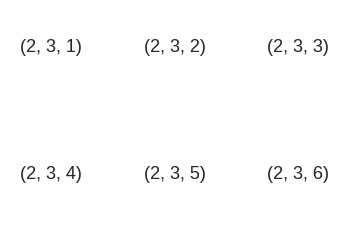

In [0]:
fig = plt.figure()

fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i)
    ax.axis('off')
    ax.text(0.5, 0.5, str((2, 3, i)), fontsize = 18, ha = 'center')

### Задание 2

Проверьте, что классы являются сбалансированными, т.е. количество изображений, принадлежащих каждому из классов, примерно одинаково (в данной задаче 10 классов).

### Задание 3

Разделите данные на три подвыборки: обучающую (200 тыс. изображений), валидационную (10 тыс. изображений) и контрольную (тестовую) (19 тыс. изображений).

### Задание 4

Проверьте, что данные из обучающей выборки не пересекаются с данными из валидационной и контрольной выборок. Другими словами, избавьтесь от дубликатов в обучающей выборке.

### Задание 5

Постройте простейший классификатор (например, с помощью логистической регрессии). Постройте график зависимости точности классификатора от размера обучающей выборки (50, 100, 1000, 50000). Для построения классификатора можете использовать библиотеку _SkLearn_ (http://scikit-learn.org).